In [1]:
# Math and Plotting
import numpy as np                         
import matplotlib.pyplot as plt             
# from pyscenarios.sobol import sobol  
from scipy import constants, interpolate
%matplotlib inline
import itertools
import math

# Basic Data Imports
import time
from pickle import dump, load    
import pandas as pd

# RDF Analysis and Simulations
import freud
import gsd.hoomd
import hoomd
from utility.hoomd_sim import mie_fluid

# Parallel Computing
import dask
from dask.distributed import Client, progress
from matplotlib.pyplot import figure
from dask import config as cfg
import warnings

[1.85016637 1.89247046 1.93296333 1.97182723]
Number of Experiments: 19


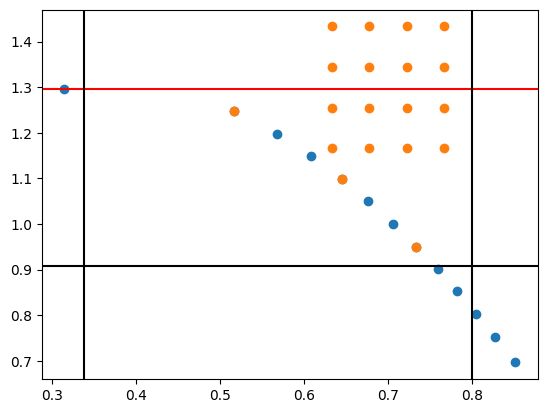

In [3]:
import pandas as pd
df = pd.read_csv('plot-data.csv')
ρ_vle = df.to_numpy()[:,0]
T_vle = df.to_numpy()[:,1]
# print(ρ_vle[0])

#defined on rho^* T^*
ranges = np.array([[0.6, 0.8],
                   [1.1, 1.5]])

num = 4
n   = 12
#n_range = np.linspace(ranges[0,0] + (ranges[0,1] - ranges[0,0])/6 ,ranges[0,1] - (ranges[0,1] - ranges[0,0])/6,num)
σ_range = np.linspace(ranges[0,0] + (ranges[0,1] - ranges[0,0])/6 ,ranges[0,1] - (ranges[0,1] - ranges[0,0])/6,num)
ϵ_range = np.linspace(ranges[1,0] + (ranges[1,1] - ranges[1,0])/6 ,ranges[1,1] - (ranges[1,1] - ranges[1,0])/6,num)

print((σ_range/0.1)**(1/3))

exp_params = []

# for n in n_range:
for σ in σ_range:
    for ϵ in ϵ_range:
        exp_params.append([n,σ,ϵ])
exp_params.append([12, ρ_vle[1], T_vle[1]])
exp_params.append([12, ρ_vle[4], T_vle[4]])
exp_params.append([12, ρ_vle[7], T_vle[7]])
print("Number of Experiments:", len(exp_params))

#plt.scatter(rho_points, T_points)
plt.scatter(ρ_vle, T_vle)
plt.scatter(np.array(exp_params).T[1], np.array(exp_params).T[2])
plt.axhline(T_vle[0], color = 'r')
plt.axvline(0.1*2**3, color = 'k')
plt.axvline(0.1*1.5**3, color = 'k')
plt.axhline(1/1.1, color = 'k')
# plt.axhline(1/0.1, color = 'k')
plt.xlim()
plt.show()

In [4]:
print((np.array(exp_params).T[1]/0.1)**(1/3))
print(1/(np.array(exp_params).T[2]))

exp_params_mie = [(np.array(exp_params).T[1]/0.1)**(1/3), 1/(np.array(exp_params).T[2])]
exp_params_mie = (np.array(exp_params_mie).T)

[1.85016637 1.85016637 1.85016637 1.85016637 1.89247046 1.89247046
 1.89247046 1.89247046 1.93296333 1.93296333 1.93296333 1.93296333
 1.97182723 1.97182723 1.97182723 1.97182723 1.72914768 1.86135982
 1.94282556]
[0.85714286 0.79646018 0.74380165 0.69767442 0.85714286 0.79646018
 0.74380165 0.69767442 0.85714286 0.79646018 0.74380165 0.69767442
 0.85714286 0.79646018 0.74380165 0.69767442 0.80102968 0.91018582
 1.05210819]


In [5]:
exp_params_mie[0][0]

1.8501663676371822

In [6]:
N_particles = 1_000
name = "A"
timestep = 0.005 
#Assume a base case of kbT = 1 and ρ = 0.1 to define ranges for simulations based on the phase diagram of Mie fluid
kbT = 1
density = 0.1
#
eq_time = 50_000
production_time = 5e5
path = "exp_data"

In [7]:
cfg.set({'distributed.scheduler.worker-ttl': None}) # This stops dask from crying when the sims take a long time.
client = Client(n_workers=80)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 80
Total threads: 80,Total memory: 187.40 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34413,Workers: 80
Dashboard: http://127.0.0.1:8787/status,Total threads: 80
Started: Just now,Total memory: 187.40 GiB
Comm: tcp://127.0.0.1:33883,Total threads: 1
Dashboard: http://127.0.0.1:33607/status,Memory: 2.34 GiB
Nanny: tcp://127.0.0.1:34521,


In [8]:
# Queue up function calls into dask
lazy_results = []
for i in range (len(exp_params_mie)):
    lazy_results.append(dask.delayed(mie_fluid)(path, "_exp_" + str(i), N_particles, exp_params_mie[i][0]*2.5, name, timestep, 
                                                 12, exp_params_mie[i][0], exp_params_mie[i][1],
                                                 kbT, density, eq_time, production_time))

# Allow dask to parallelize the set of simulations and run them
results = dask.compute(*lazy_results)

notice(2): Setting number of TBB threads to value of OMP_NUM_THREADS=1
notice(2): Setting number of TBB threads to value of OMP_NUM_THREADS=1
notice(2): Setting number of TBB threads to value of OMP_NUM_THREADS=1
notice(2): Setting number of TBB threads to value of OMP_NUM_THREADS=1
notice(2): Setting number of TBB threads to value of OMP_NUM_THREADS=1
notice(2): Setting number of TBB threads to value of OMP_NUM_THREADS=1
notice(2): Setting number of TBB threads to value of OMP_NUM_THREADS=1
notice(2): Setting number of TBB threads to value of OMP_NUM_THREADS=1
notice(2): Setting number of TBB threads to value of OMP_NUM_THREADS=1
notice(2): Setting number of TBB threads to value of OMP_NUM_THREADS=1
notice(2): Setting number of TBB threads to value of OMP_NUM_THREADS=1
notice(2): Setting number of TBB threads to value of OMP_NUM_THREADS=1
notice(2): Setting number of TBB threads to value of OMP_NUM_THREADS=1
notice(2): Setting number of TBB threads to value of OMP_NUM_THREADS=1
notice

In [9]:
rmax = (0.95/2)*((N_particles/density)**(1/3))
rmin = 0
rnum = 250
r = np.linspace(rmin,rmax,rnum)

#assume atom size of ~2.5 A^-1
qmax = np.pi/(2.5*(rmax - rmin)/rnum) #qmax in reduced space is (π/Δr)*1/2.5
qmin = 1.25                           #qmin in reduced space is qmin for standard diffractometers * 2.5 A
qnum = 236                            #qnum selected so that the spacing is approximately 0.05A^{-1} for a 2.5 A particle
q = np.linspace(qmin,qmax,qnum) 
print('qmin =', qmin)
print('qmax =', qmax)
print('Δq =', q[1]- q[0])

qmin = 1.25
qmax = 30.698908169815425
Δq = 0.12531450285027845


In [10]:
traj = gsd.hoomd.open('exp_data/traj/mie_exp_' + str(0) + '.gsd', 'r')
box = freud.box.Box.from_box(traj[0].configuration.box[:3])

In [11]:
rdfs = np.empty((19,rnum))

for i in range(19):
    # Create a freud compute object (RDF is the canonical example)
    rdf = freud.density.RDF(bins=rnum, r_min = rmin, r_max=rmax)
    
    # Load a GSD trajectory (see docs for other formats)
    traj = gsd.hoomd.open('exp_data/traj/mie_exp_' + str(i) + '.gsd', 'r')
    for frame in traj:
        rdf.compute(system=(box,frame.particles.position), reset=False)
    # Get bin centers, RDF data from attributes
    rdfs[i] = rdf.rdf

    if i % 10 == 0:
        print("Completed Itr",i)

Completed Itr 0
Completed Itr 10


In [12]:
def rdf2sq(r, rdf, Qmin, Qmax, Qnum, ρ):
    q = np.linspace(Qmin, Qmax, Qnum)
    dr = r[1] - r[0] # Stepsize
    sq   = np.zeros(len(q))
    for j in range (len(q)):
        sq[j] = (1 + 4*np.pi*ρ*np.trapz(r*(rdf-1)*np.sin(q[j]*r),dx = dr)/q[j])
    return q, sq

In [13]:
sqs = np.empty((19,qnum))

for i in range(19):
    sqs[i] = rdf2sq(rdf.bin_centers,rdfs[i],qmin,qmax,qnum,density)[1]

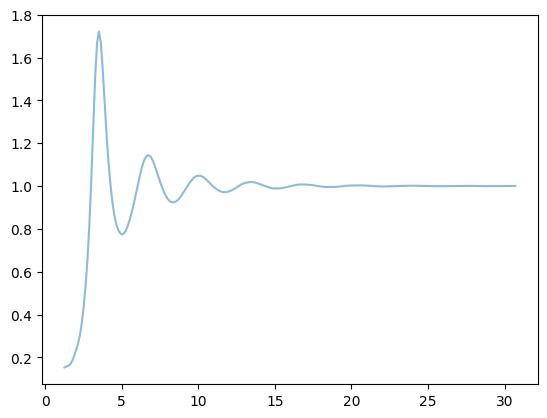

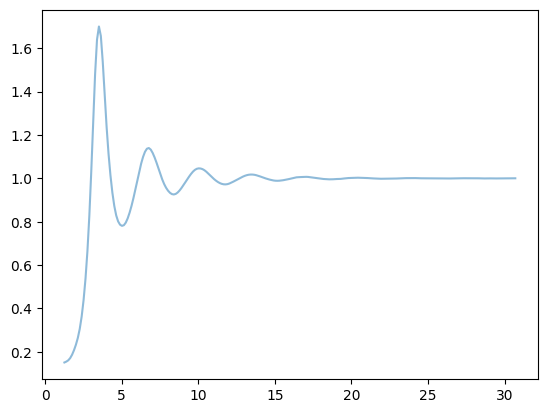

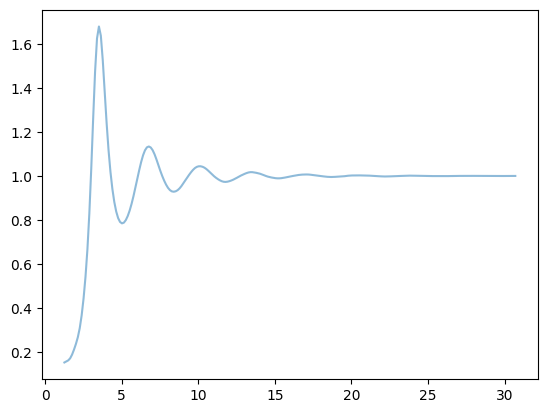

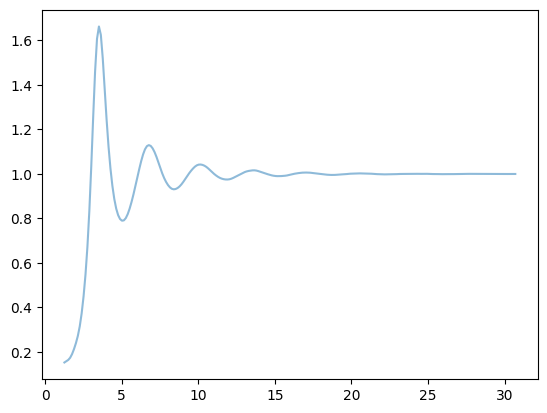

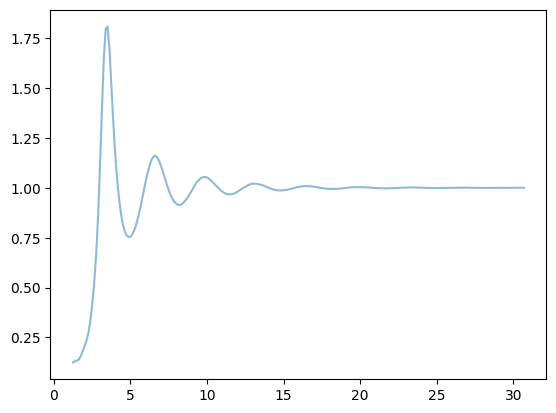

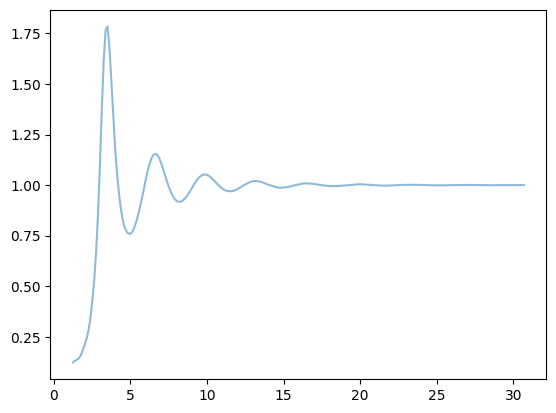

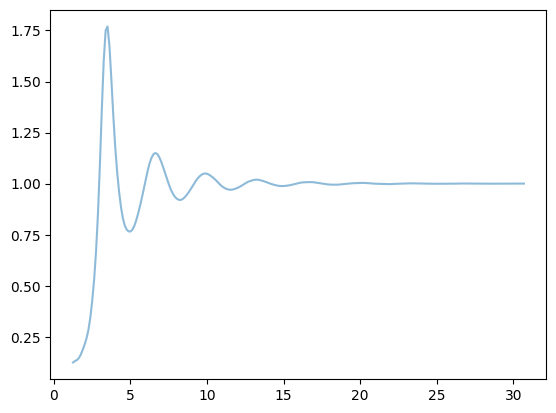

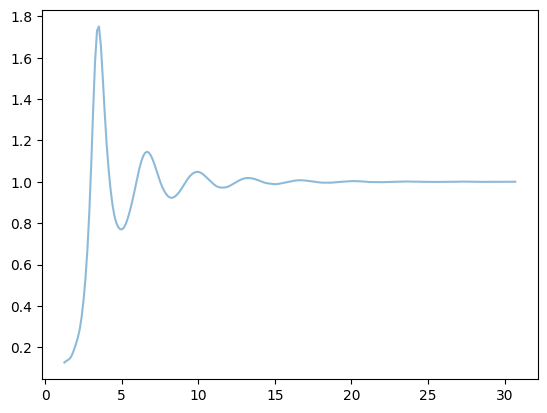

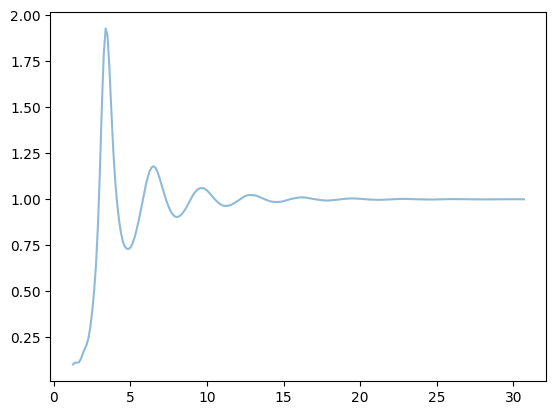

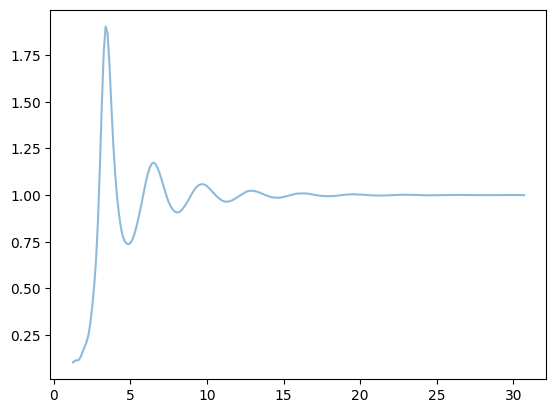

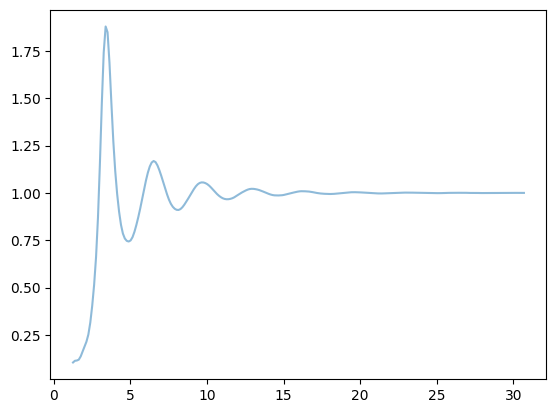

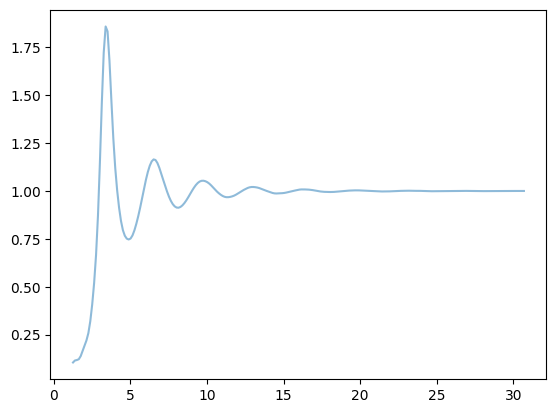

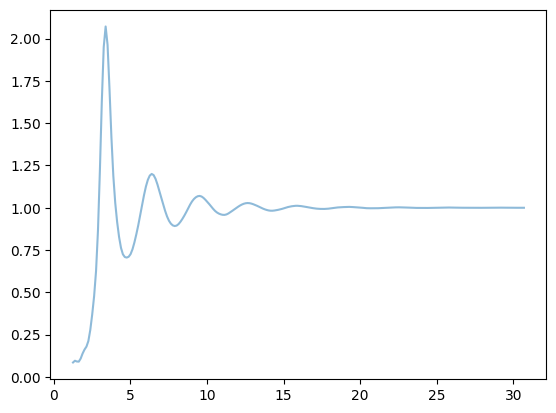

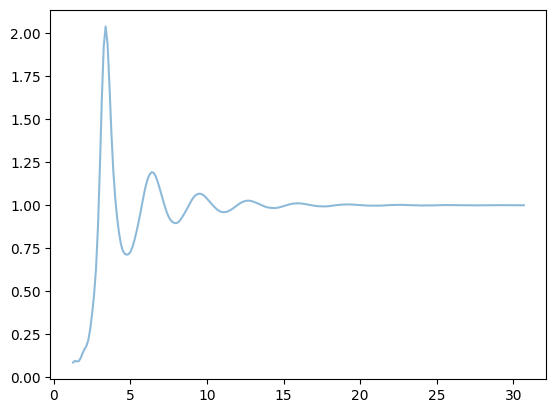

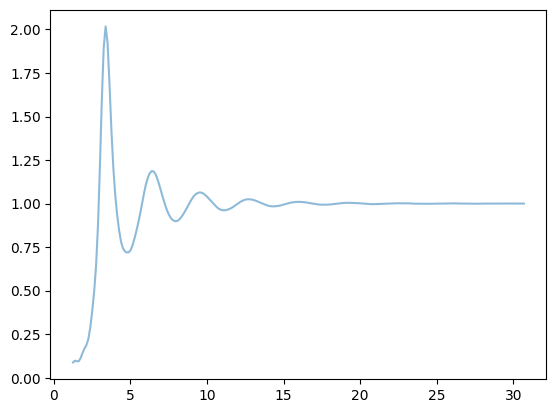

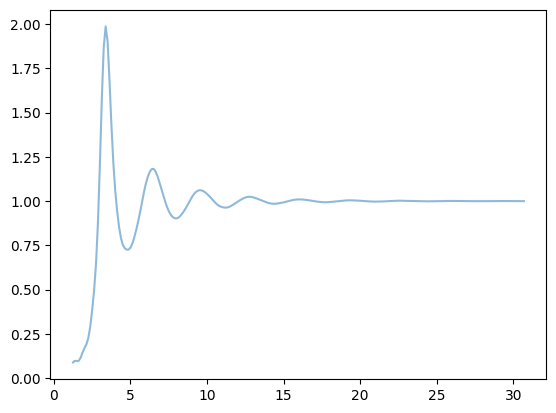

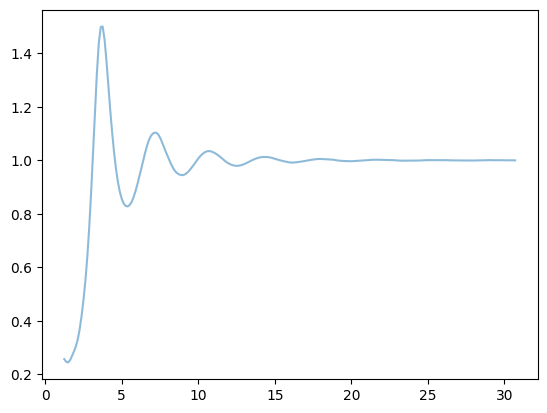

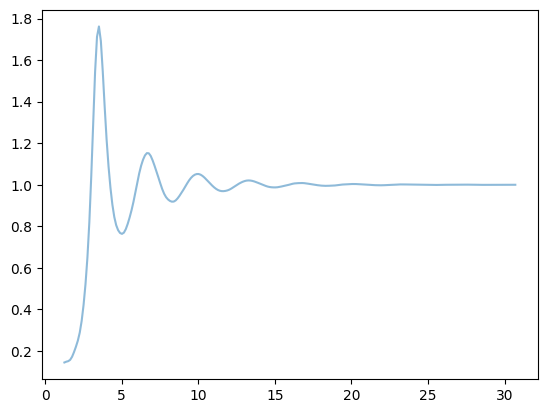

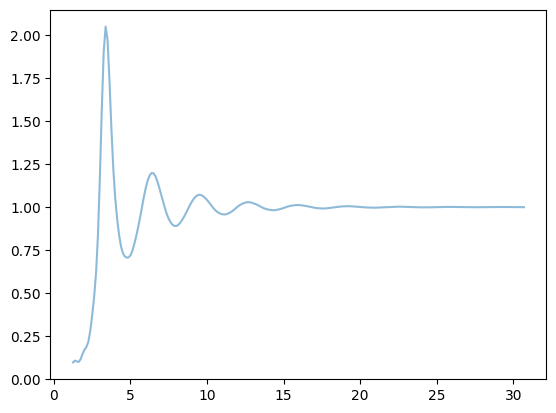

[12, 0.6333333333333333, 1.1666666666666667]


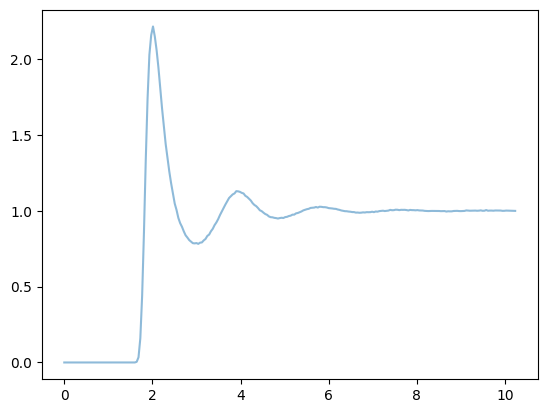

[12, 0.6333333333333333, 1.2555555555555555]


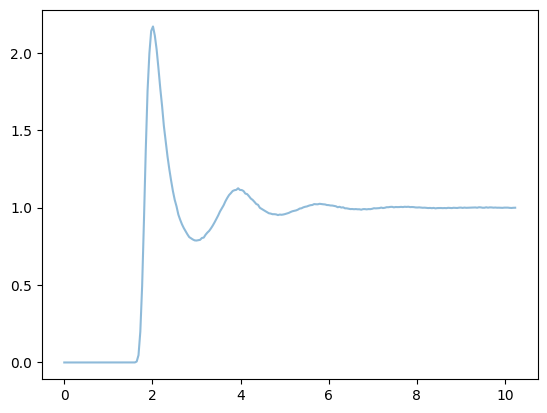

[12, 0.6333333333333333, 1.3444444444444446]


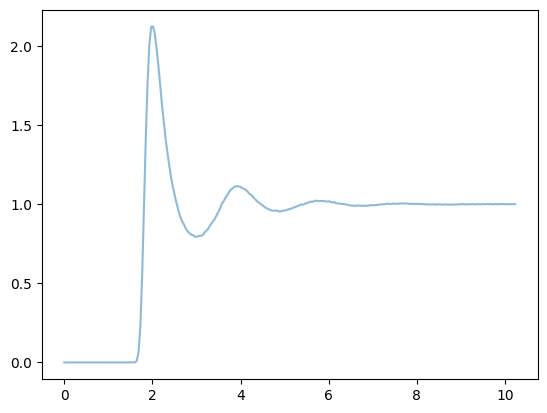

[12, 0.6333333333333333, 1.4333333333333333]


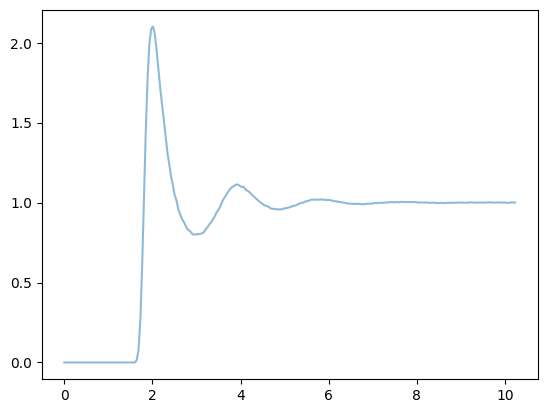

[12, 0.6777777777777778, 1.1666666666666667]


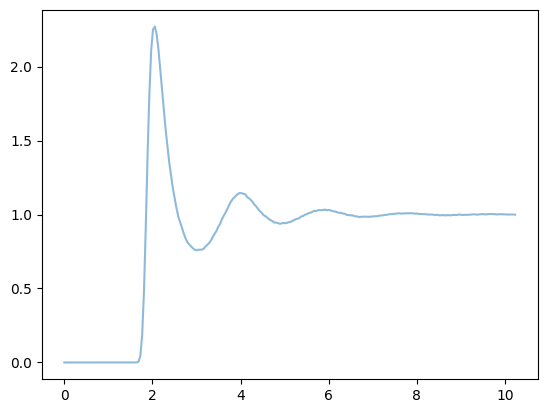

[12, 0.6777777777777778, 1.2555555555555555]


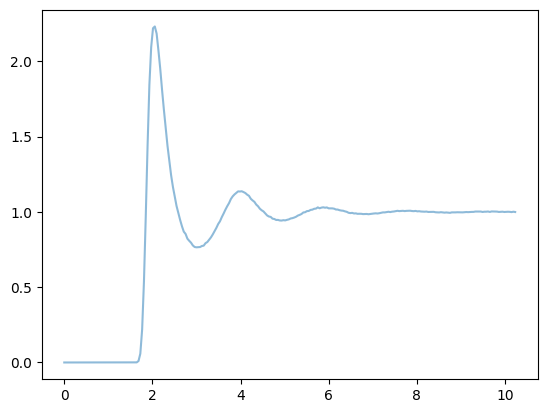

[12, 0.6777777777777778, 1.3444444444444446]


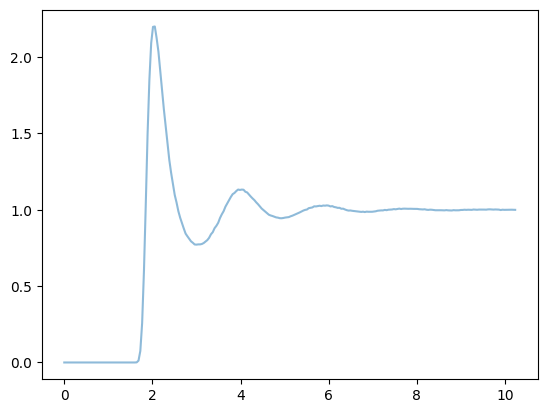

[12, 0.6777777777777778, 1.4333333333333333]


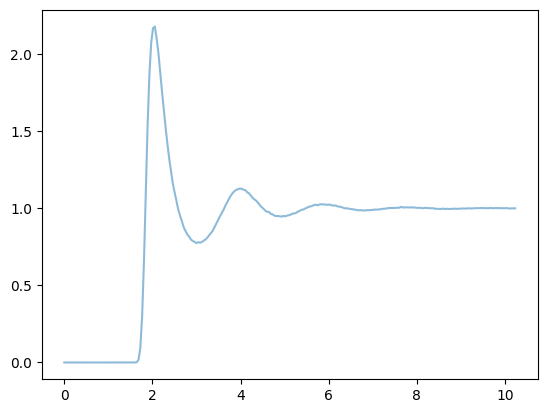

[12, 0.7222222222222222, 1.1666666666666667]


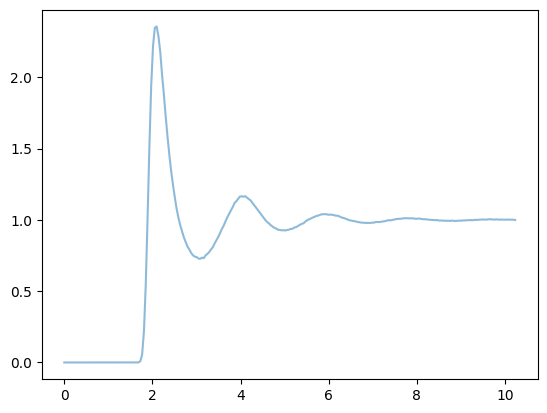

[12, 0.7222222222222222, 1.2555555555555555]


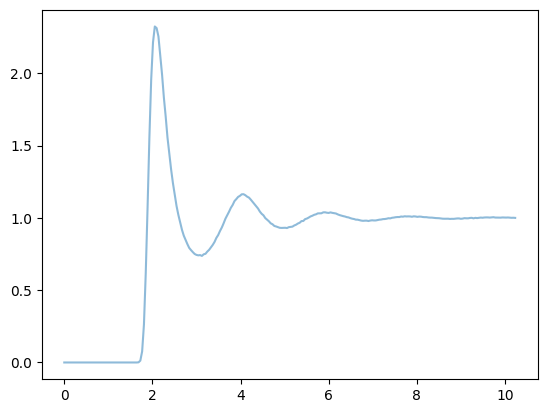

[12, 0.7222222222222222, 1.3444444444444446]


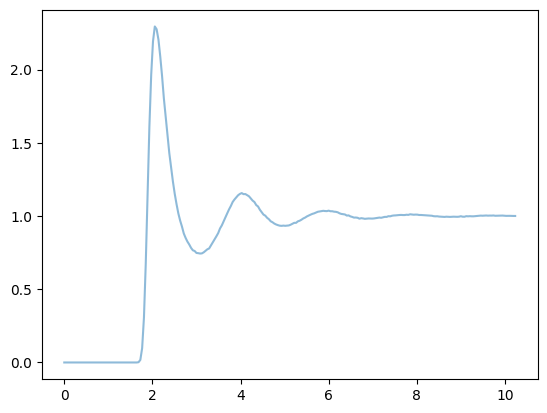

[12, 0.7222222222222222, 1.4333333333333333]


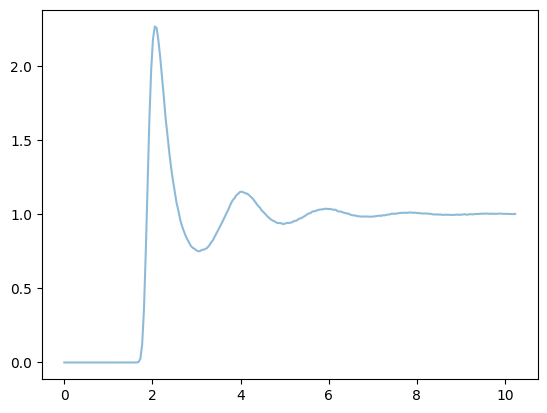

[12, 0.7666666666666667, 1.1666666666666667]


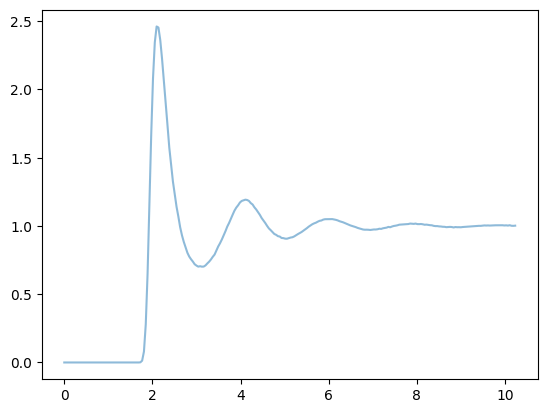

[12, 0.7666666666666667, 1.2555555555555555]


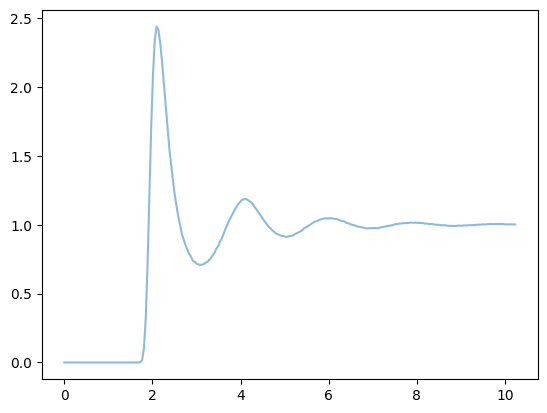

[12, 0.7666666666666667, 1.3444444444444446]


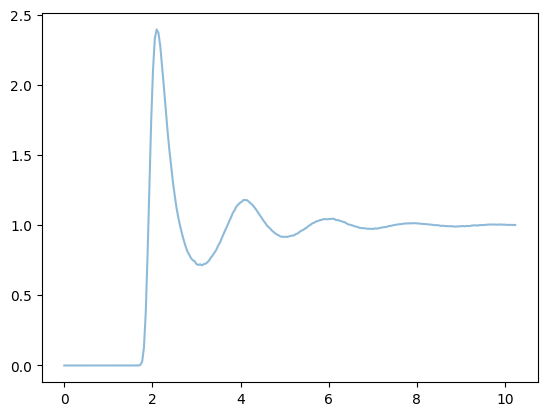

[12, 0.7666666666666667, 1.4333333333333333]


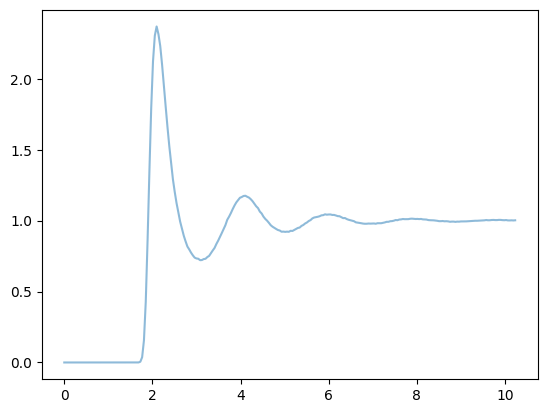

[12, 0.5170068027210885, 1.2483931947069942]


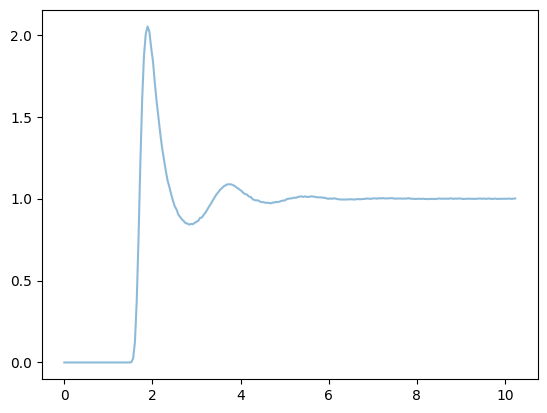

[12, 0.6448979591836735, 1.0986767485822306]


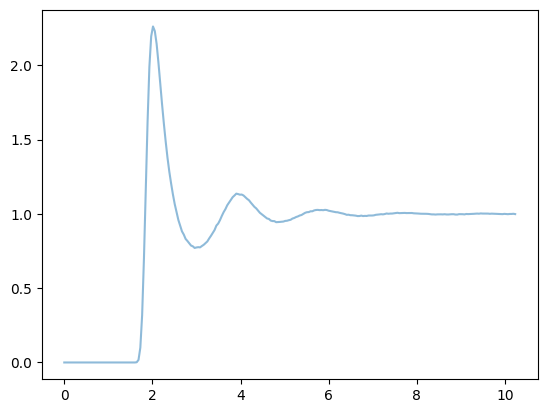

[12, 0.7333333333333334, 0.9504725897920604]


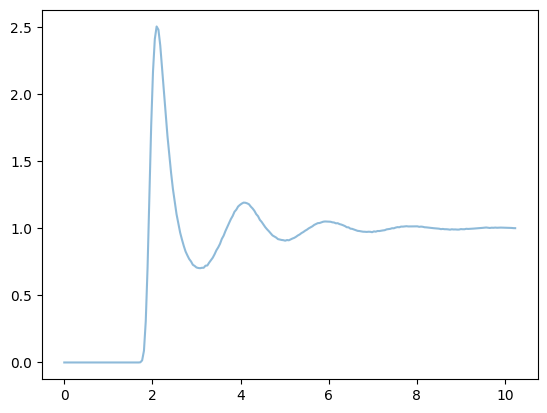

In [14]:
for i in range(19):
    plt.plot(q,sqs[i],alpha=0.5)
    plt.show()

for i in range(19):
    print(exp_params[i])
    plt.plot(r,rdfs[i],alpha=0.5)
    plt.show()

In [16]:
# Save the input samples
output_dict = dict(exp_params = exp_params_mie, sqs = sqs, rdfs = rdfs)
dump(output_dict, open('exp_data/experimental_data_NEW.p', 'wb'))